In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier



In [21]:

# Load your dataset
data = np.load('development_numpy/development.npy', allow_pickle=True)
metadata = pd.read_csv('metadata/development.csv')
feature_names_mapping = pd.read_csv('metadata/idx_to_feature_name.csv')

# Extract labels
labels = metadata['word'].values

# Subsample the data (e.g., 40% of the original dataset)
subsample_fraction = 1.0
X_subsample, _, y_subsample, _, snippet_ids_subsample, _ = train_test_split(
    data, labels, np.arange(len(metadata)), train_size=subsample_fraction, random_state=42)

# Flatten the feature dimensions (n_features * n_time)
n_samples, n_features, n_time = X_subsample.shape
X_subsample_flat = X_subsample.reshape(n_samples, n_features * n_time)

# Split the data into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_subsample_flat, y_subsample, test_size=0.3, random_state=42, stratify=y_subsample)


InvalidParameterError: The 'train_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 1.0 instead.

In [ ]:
# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_val, y_train_val)

# Check the class distribution after applying SMOTE
unique, counts = np.unique(y_resampled, return_counts=True)
print(f"Class distribution after SMOTE: {dict(zip(unique, counts))}")


Class distribution after SMOTE: {'Alarm': 1242, 'Brötchen': 1242, 'Fernseher': 1242, 'Haus': 1242, 'Heizung': 1242, 'Leitung': 1242, 'Licht': 1242, 'Lüftung': 1242, 'Ofen': 1242, 'Radio': 1242, 'Schraube': 1242, 'Spiegel': 1242, 'Staubsauger': 1242, 'an': 1242, 'aus': 1242, 'kann': 1242, 'nicht': 1242, 'offen': 1242, 'other': 1242, 'warm': 1242, 'wunderbar': 1242}


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Feature selection using RandomForestClassifier
feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
feature_selector.fit(X_train_scaled, y_resampled)
sfm = SelectFromModel(feature_selector, threshold="mean")
X_train_important = sfm.transform(X_train_scaled)
X_test_important = sfm.transform(X_test_scaled)


In [ ]:
# Train the SVM model
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train_important, y_resampled)


In [22]:
# Train the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_model.fit(X_train_important, y_resampled)

KNeighborsClassifier()

In [23]:
# Train the Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
nn_model.fit(X_train_important, y_resampled)


In [ ]:
# Predict on the test set

def evaluate_model(model):
    y_pred = model.predict(X_test_important)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Visualize the confusion matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


              precision    recall  f1-score   support

       Alarm       0.82      0.82      0.82       245
    Brötchen       0.87      0.91      0.89       245
   Fernseher       0.86      0.91      0.89       247
        Haus       0.87      0.81      0.84       232
     Heizung       0.89      0.91      0.90       246
     Leitung       0.91      0.93      0.92       242
       Licht       0.88      0.88      0.88       253
     Lüftung       0.95      0.91      0.93       252
        Ofen       0.74      0.74      0.74       248
       Radio       0.90      0.86      0.88       251
    Schraube       0.91      0.92      0.92       253
     Spiegel       0.95      0.93      0.94       245
 Staubsauger       0.94      0.92      0.93       254
          an       0.84      0.85      0.85       241
         aus       0.82      0.89      0.86       244
        kann       0.88      0.86      0.87       253
       nicht       0.86      0.89      0.88       234
       offen       0.70    

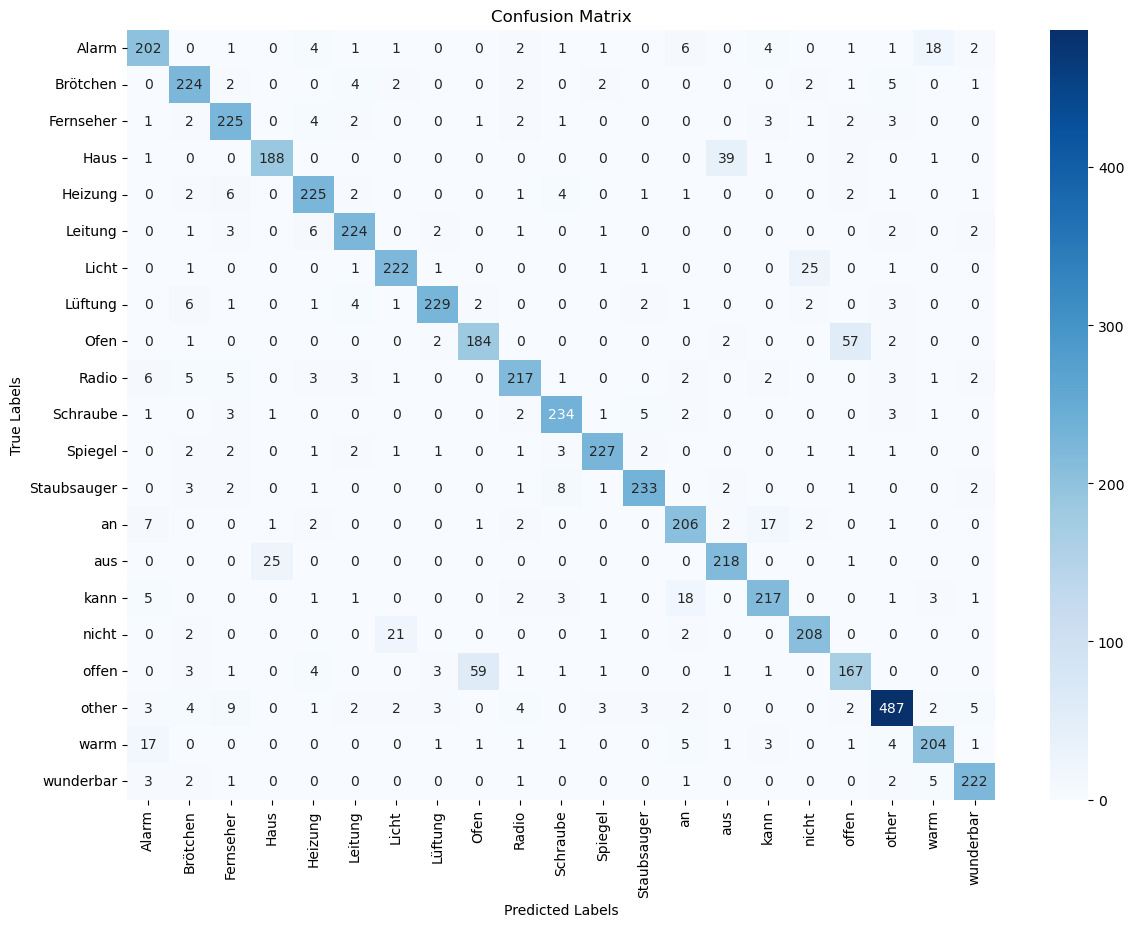

In [ ]:
evaluate_model(svm_model)

              precision    recall  f1-score   support

       Alarm       0.95      0.90      0.92       245
    Brötchen       0.91      0.96      0.93       245
   Fernseher       0.94      0.94      0.94       247
        Haus       0.91      0.82      0.86       232
     Heizung       0.95      0.92      0.93       246
     Leitung       0.94      0.94      0.94       242
       Licht       0.93      0.89      0.91       253
     Lüftung       0.96      0.95      0.95       252
        Ofen       0.78      0.80      0.79       248
       Radio       0.96      0.94      0.95       251
    Schraube       0.95      0.95      0.95       253
     Spiegel       0.97      0.95      0.96       245
 Staubsauger       0.93      0.94      0.94       254
          an       0.89      0.93      0.91       241
         aus       0.83      0.91      0.86       244
        kann       0.88      0.92      0.90       253
       nicht       0.87      0.92      0.90       234
       offen       0.76    

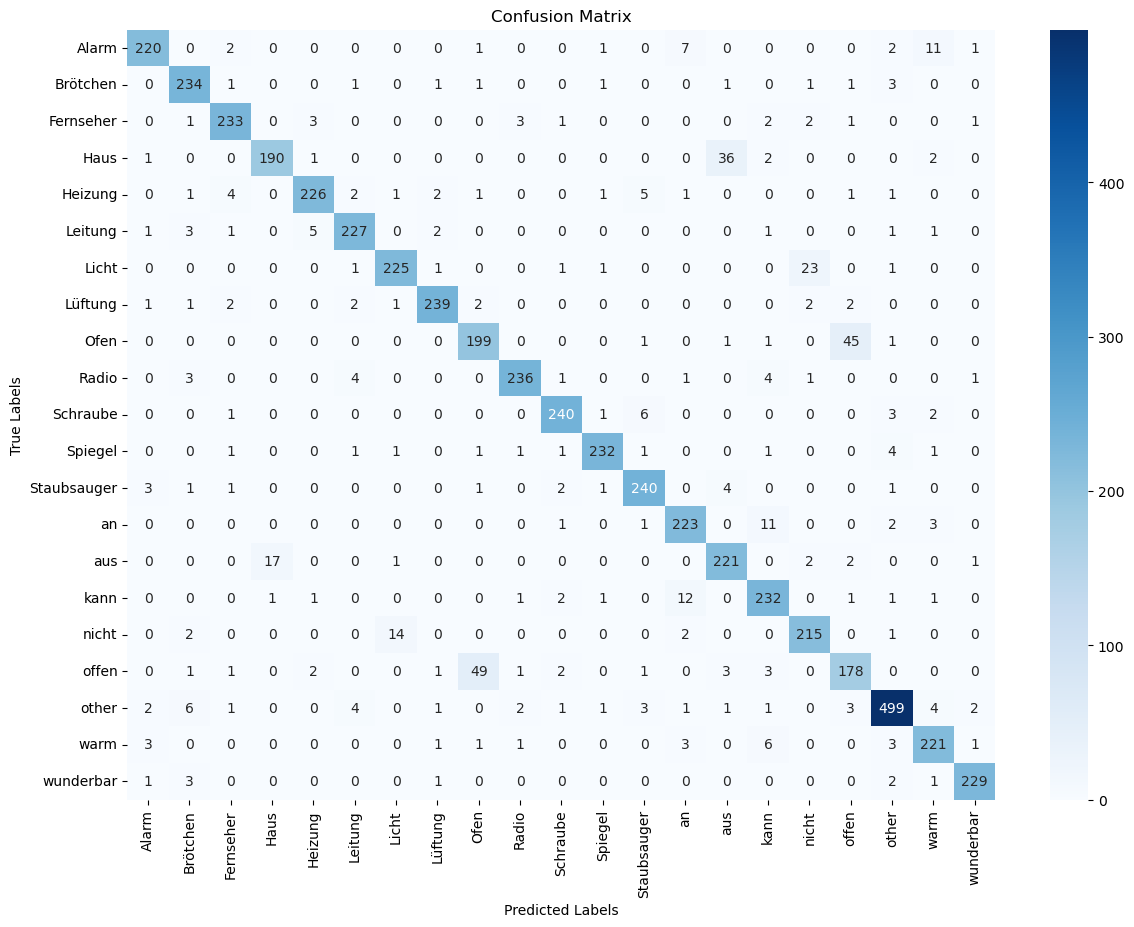

In [ ]:
evaluate_model(nn_model)

              precision    recall  f1-score   support

       Alarm       0.91      0.91      0.91       245
    Brötchen       0.93      0.92      0.93       245
   Fernseher       0.91      0.94      0.93       247
        Haus       0.82      0.83      0.83       232
     Heizung       0.92      0.94      0.93       246
     Leitung       0.94      0.93      0.94       242
       Licht       0.79      0.73      0.76       253
     Lüftung       0.92      0.95      0.94       252
        Ofen       0.77      0.76      0.77       248
       Radio       0.96      0.97      0.96       251
    Schraube       0.95      0.96      0.96       253
     Spiegel       0.97      0.96      0.97       245
 Staubsauger       0.98      0.95      0.97       254
          an       0.77      0.88      0.82       241
         aus       0.84      0.84      0.84       244
        kann       0.84      0.85      0.84       253
       nicht       0.73      0.80      0.77       234
       offen       0.77    

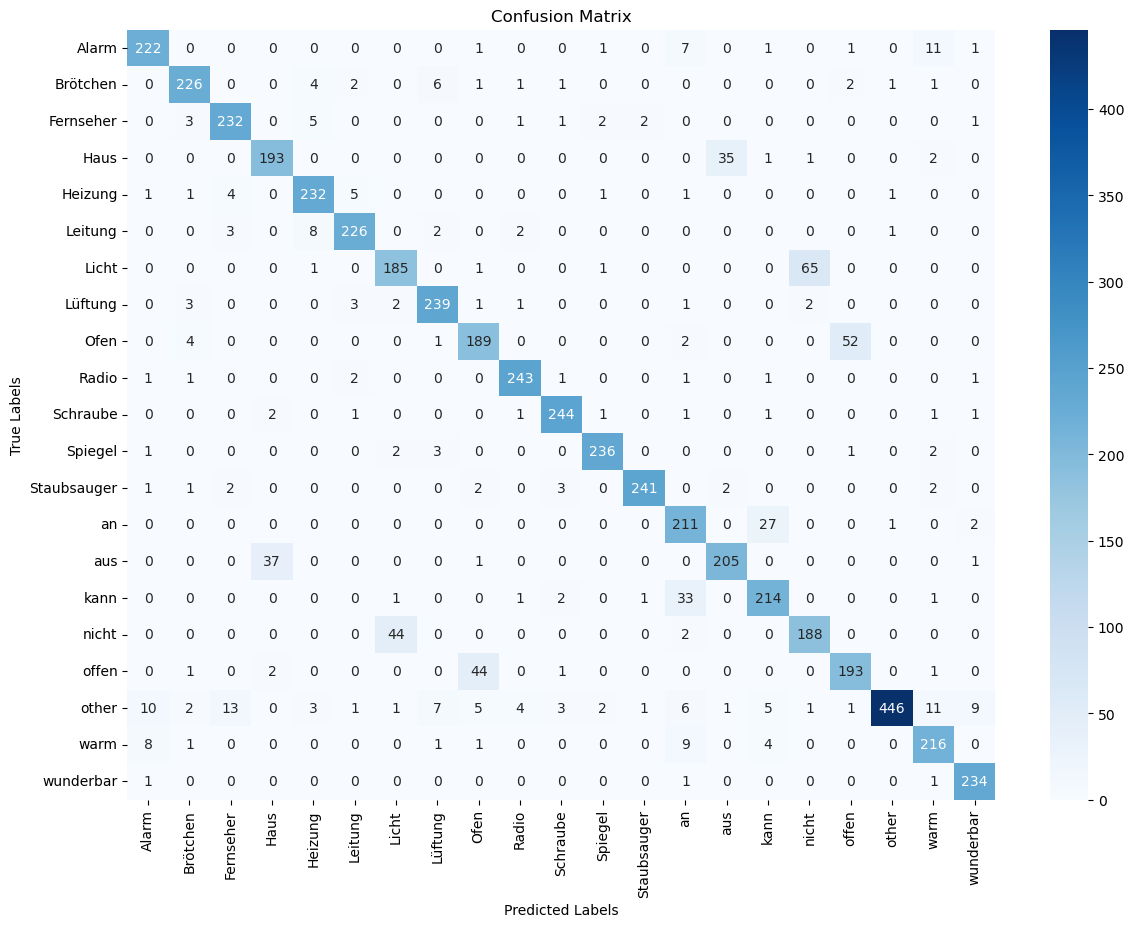

In [ ]:
evaluate_model(knn_model)

In [ ]:
def predict_word(svm_model, scaler, sfm, word_index, test_data, test_labels):
    """
    Predict the class label for a given word using the trained SVM model.

    :param svm_model: Trained SVM model
    :param scaler: StandardScaler used for feature scaling
    :param sfm: SelectFromModel used for feature selection
    :param word_index: Index of the word in the test data
    :param test_data: Test data set
    :param test_labels: Corresponding labels for the test data
    :return: Predicted class label
    """
    # Get the corresponding features for the word
    word_features = test_data[word_index].reshape(1, -1)
    
    # Scale the features
    word_features_scaled = scaler.transform(word_features)
    
    # Select important features
    word_features_important = sfm.transform(word_features_scaled)
    
    # Predict the class label
    prediction = svm_model.predict(word_features_important)
    
    return prediction[0]

# Example usage:
# Predict labels for a sample of words from the test set
sample_indices = np.random.choice(len(y_test), 10, replace=False)
for idx in sample_indices:
    example_word = y_test[idx]
    predicted_label = predict_word(svm_model, scaler, sfm, idx, X_test_scaled, y_test)
    print(f"True label: {example_word} | Predicted label: {predicted_label}")


True label: Fernseher | Predicted label: Heizung
True label: aus | Predicted label: Haus
True label: Licht | Predicted label: Haus
True label: other | Predicted label: other
True label: kann | Predicted label: kann
True label: wunderbar | Predicted label: Licht
True label: Ofen | Predicted label: Spiegel
True label: an | Predicted label: Haus
True label: aus | Predicted label: aus
True label: other | Predicted label: other


In [ ]:
# Train the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_model.fit(X_train_important, y_resampled)


KNeighborsClassifier()